# Mixture Models for Least Square Optimization

## Problem Formulation

The goal is to infer the posterior distribution of the state variable $x$ conditioned on sensor observations z
$$
x^* = \underset{x}{\operatorname{argmax}} p (x | z)
$$
By applying Bayes' rule and assuming uninformative prior $p(x)$, maximizing posterior distribution is same as maximizing likelihood distribution:
$$
x^* = \underset{x}{\operatorname{argmax}} p (x | z) = x^* = \underset{x}{\operatorname{argmax}} p (z | x)
$$
If we assume all observations $z$ are independent given some related state variable $x$, we can get:
$$
x^* = \underset{x}{\operatorname{argmax}} \prod p (z_i | x) 
$$

## Factor Potentials as Gaussian

If we assume $p(z_i | x) \sim N (f_i(x)-z_i, \Sigma_i)$, then we can maximize the log-likelihood as:
$$
x^* = \underset{x}{\operatorname{argmax}} \sum_i{log(\eta_i e^{-\frac{1}{2}(f_i(x)-z_i)^T\Sigma_i^{-1}(f_i(x)-z_i)})}
$$
It then turns into a least square problem:
$$
x^* = \underset{x}{\operatorname{argmin}} \sum_i{(f_i(x)-z_i)^T\Sigma_i^{-1}(f_i(x)-z_i)} = \underset{x}{\operatorname{argmin}} \sum_i{\|f_i(x) - z_i\|_{\Sigma_i}}
$$
For the sack of simplicity, we assume $f_i$ are linear functions (We can always linearize it as $f_i(x) \approx J_i(x-x_0) + f_x(x_0)$). Then this becomes a linear least square problem, and the cost function is quadratic and convex. 

### A Simple Linear Regression 
Consider a very simple linear regression problem. In order to visualize the loss vs parameter in a 2D plot, we parameterize the line as $y = ax$. If we assume $\Sigma_i = I$, then
$$
a^* = \sum_{i}(ax_i - y_i)^2
$$ 
As shown in the figure below, the cost function is clearly a quadratic function.

Best $a$ with least loss is 1.00


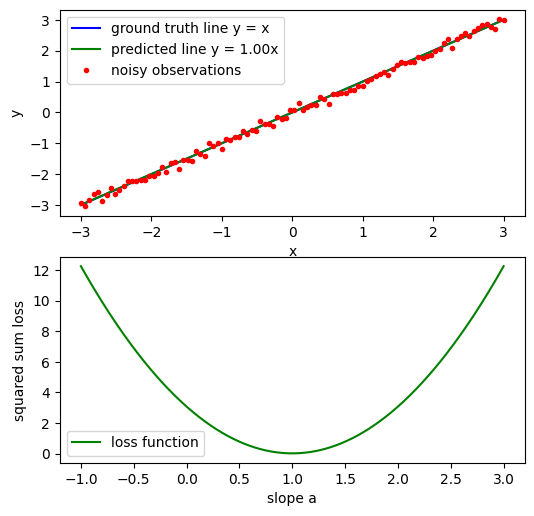

In [48]:
# A Simple Linear Regression

import numpy as np
import matplotlib.pyplot as plt

a = 1
x = np.linspace(-3, 3, 100)
y = a * x 
y_hat = y + np.random.normal(0, 0.1, x.shape)

a_hat = np.linspace(-1, 3, 1000)
losses = [np.sum((t*x-y_hat)**2)/x.shape[0] for t in a_hat]

a_best = a_hat[np.argmin(losses)]
print(f'Best $a$ with least loss is {a_best:.2f}')

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6,6), dpi=100)

ax1.plot(x, y, '-b', label='ground truth line y = x')
ax1.plot(x, a_best*x, '-g', label=f'predicted line y = {a_best:.2f}x')
ax1.plot(x, y_hat, 'r.', label='noisy observations')
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.legend()

ax2.plot(a_hat, losses, '-g', label='loss function')
ax2.set_ylabel('squared sum loss')
ax2.set_xlabel('slope a')
ax2.legend()

#

### A Simple Linear Regression With Outliers

However, the approach described above is very sensitive to outliers. Let's add a couple of outliers to the measurements. As you can see, the estimation is off. This is because these outliers contribute more errors to the cost function. The optimizer tries to reduce these errors. 

Best $a$ with least loss is 0.73


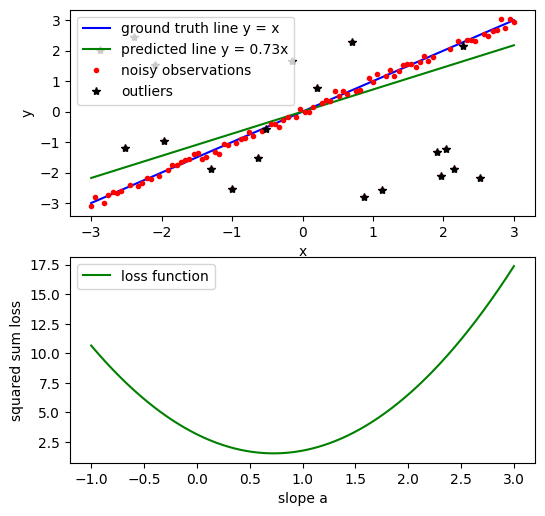

In [49]:
# A Simple Linear Regression with outliers

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

npoints = 100
a = 1
x = np.linspace(-3, 3, npoints)
y = a * x 
y_hat = y + np.random.normal(0, 0.1, x.shape)

n_outliers = 20
rng = np.random.default_rng()
outlier_indices = rng.choice(npoints, size=n_outliers, replace=False)
# In most practical applications, residuals are not Gaussian distributed.
y_hat[outlier_indices] = np.random.uniform(-3, 3, n_outliers)

a_hat = np.linspace(-1, 3, 1000)
losses = [np.sum((t*x-y_hat)**2)/x.shape[0] for t in a_hat]

a_best = a_hat[np.argmin(losses)]
print(f'Best $a$ with least loss is {a_best:.2f}')

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6,6), dpi=100)

ax1.plot(x, y, '-b', label='ground truth line y = x')
ax1.plot(x, a_best*x, '-g', label=f'predicted line y = {a_best:.2f}x')
ax1.plot(x, y_hat, 'r.', label='noisy observations')
ax1.plot(x[outlier_indices], y_hat[outlier_indices], 'k*', label='outliers')
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.legend()

ax2.plot(a_hat, losses, '-g', label='loss function')
ax2.set_ylabel('squared sum loss')
ax2.set_xlabel('slope a')
ax2.legend()

#

### Robust Kernels

How do we make the optimization more robust to outliers? 
1. Detect the outliers before running optimization so that we never use them in the optimization.
2. Give less weights for outliers in the optimization. Outliers usually have large errors (residual) compared to normal data assume that the initial guesses of the state variables are not very off.

For (2), we can replace the $L_2$ norm with robust kernels (M-estimators):
$$
x^*  = \underset{x}{\operatorname{argmin}} \sum_i{\rho(r_i(x))}
$$
where $r_i(x) = |f_i(x) - z_i|{\Sigma_i}^{-\frac{1}{2}}$, $\rho()$ is a function designed to reduce the influence of large residuals.  

#### Huber Loss
One common robust kernel is Huber loss:
$$
\rho(r) = \begin{cases}
\frac{r^2}{2} &\text{$|r| < k$}\\
k(|r|-\frac{k}{2}) &\text{$|r| \geq k$}
\end{cases}
$$

$$
\frac{\partial L}{\partial x} = \sum_i{\frac{\partial \rho(r_i)}{\partial r_i}\frac{\partial r_i(x)}{\partial x_i}}
$$

We define $\phi = \frac{\partial \rho(r_i)}{\partial r_i}$, then
$$
\frac{\partial L}{\partial x} = \sum_i{\frac{\phi}{r_i}r_i\frac{\partial r_i(x)}{\partial x_i}}
$$

We define $w = \frac{\phi}{r_i}$, then it turns out that we can formulate loss L as:
$$
L = \sum_i{w(r_i(x_c))r^2_i(x)}
$$
where, $x_c$ is the current most recent estimate of $x$, aka linearization point. 

For huber loss, the weight function is:
$$
w(r) = \begin{cases}
1 &\text{$|r| < k$}\\
\frac{k}{|r|} &\text{$|r| \geq k$}
\end{cases}
$$

By setting the weight function as $w = \frac{1}{r_i}\frac{\partial \rho(r_i)}{\partial r_i} |_{r_i = r_i(x_c)}$, we can solve the the optimization problem by using the existing techniques for weighted least-squares such as Gauss-Newton, Levenberg-Marquardt, etc. 

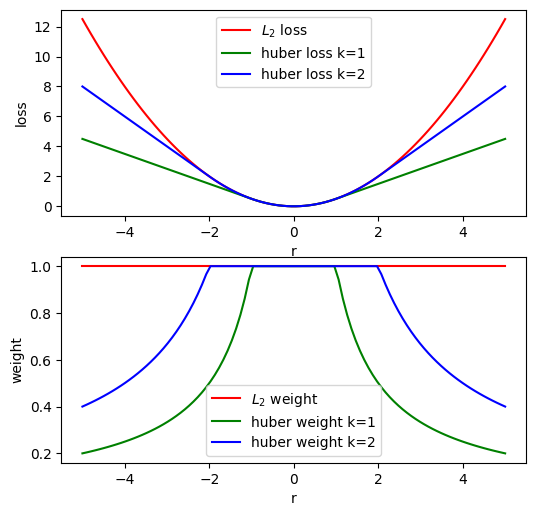

In [50]:
# Robust Kernel Functions

import matplotlib.pyplot as plt
import numpy as np

def huber_loss(r, k):
    y = np.zeros(r.shape)
    y[np.abs(r) < k] = 0.5 * (r[np.abs(r) < k] ** 2)
    y[np.abs(r) >= k] = k * (np.abs(r[np.abs(r) >= k]) - 0.5*k)
    return y

def huber_weight(r, k):
    y = np.ones(r.shape)
    y[np.abs(r) >= k] = k / np.abs(r[np.abs(r) >= k])
    return y
    
r = np.linspace(-5, 5, 100)

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6,6), dpi=100)

ax1.plot(r, 0.5 * r**2, '-r', label='$L_2$ loss')
ax1.plot(r, huber_loss(r,1), '-g', label='huber loss k=1')
ax1.plot(r, huber_loss(r,2), '-b', label='huber loss k=2')
ax1.set_ylabel('loss')
ax1.set_xlabel('r')
ax1.legend()

ax2.plot(r, np.ones(r.shape), '-r', label='$L_2$ weight')
ax2.plot(r, huber_weight(r,1), '-g', label='huber weight k=1')
ax2.plot(r, huber_weight(r,2), '-b', label='huber weight k=2')
ax2.set_ylabel('weight')
ax2.set_xlabel('r')
ax2.legend()

#

Now, we can apply Huber loss to the linear regression problem.

Best $a$ with least loss is 1.00


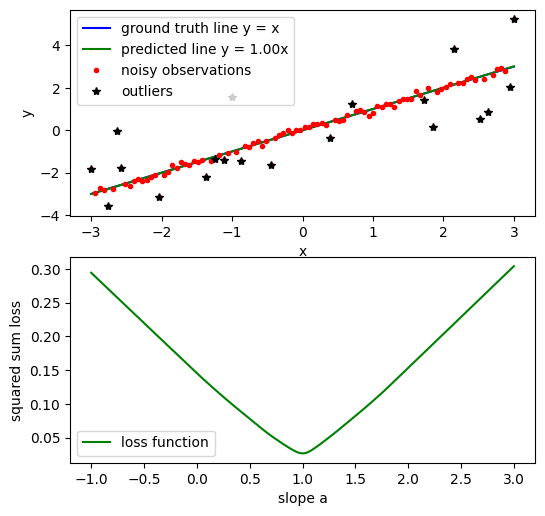

In [51]:
# A Robust Kernel based Linear Regression with outliers

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

def huber_loss(r, k):
    y = np.zeros(r.shape)
    y[np.abs(r) < k] = 0.5 * (r[np.abs(r) < k] ** 2)
    y[np.abs(r) >= k] = k * (np.abs(r[np.abs(r) >= k]) - 0.5*k)
    return y

def huber_weight(r, k):
    y = np.ones(r.shape)
    y[np.abs(r) >= k] = k / np.abs(r[np.abs(r) >= k])
    return y

npoints = 100
a = 1
x = np.linspace(-3, 3, npoints)
y = a * x 
y_hat = y + np.random.normal(0, 0.1, x.shape)

n_outliers = 20
rng = np.random.default_rng()
outlier_indices = rng.choice(npoints, size=n_outliers, replace=False)
# In most practical applications, residuals are not Gaussian distributed.
y_hat[outlier_indices] += np.random.uniform(-3, 3, n_outliers)

a_hat = np.linspace(-1, 3, 1000)
huber_k = 0.1
losses = [np.sum(huber_loss(t*x-y_hat,huber_k)) / x.shape[0] for t in a_hat]

a_best = a_hat[np.argmin(losses)]
print(f'Best $a$ with least loss is {a_best:.2f}')

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6,6), dpi=100)

ax1.plot(x, y, '-b', label='ground truth line y = x')
ax1.plot(x, a_best*x, '-g', label=f'predicted line y = {a_best:.2f}x')
ax1.plot(x, y_hat, 'r.', label='noisy observations')
ax1.plot(x[outlier_indices], y_hat[outlier_indices], 'k*', label='outliers')
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.legend()

ax2.plot(a_hat, losses, '-g', label='loss function')
ax2.set_ylabel('squared sum loss')
ax2.set_xlabel('slope a')
ax2.legend()

#

#### A Generalized Robust Kernel

A single generalized robust kernel can be express as:

$$
\rho(r, \alpha, k) = \frac{|\alpha-2|}{\alpha}((\frac{(\frac{|r|}{k})^2}{|\alpha-2|}+1)^{\frac{\alpha}{2}}-1)
$$
where $\alpha$ is a real-valued parameter that controls the shape of the kernel and $k > 0$ is the scale parameter that determines the size of quadratic loss region around $r = 0$.

With removing singularities:

$$
\rho(r, \alpha, k) = \begin{cases}
\frac{1}{2}(\frac{|r|}{k})^2 &\text{$\alpha = 2$}\\
log(\frac{1}{2}(\frac{|r|}{k})^2+1) &\text{$\alpha = 0$}\\
1 - e^{-\frac{1}{2}(\frac{|r|}{k})^2} &\text{$\alpha = -\infty$}\\
\frac{|\alpha-2|}{\alpha}((\frac{(\frac{|r|}{k})^2}{|\alpha-2|}+1)^{\frac{\alpha}{2}}-1) &\text{otherwise}
\end{cases}
$$

Then weight function $w$ is:
$$
w(r, \alpha, k) = \begin{cases} 
\frac{1}{k^2} &\text{$\alpha = 2$}\\
\frac{2}{r^2+2k^2} &\text{$\alpha = 0$}\\
\frac{1}{k^2} e^{-\frac{1}{2}(\frac{|r|}{k})^2} &\text{$\alpha = -\infty$}\\
\frac{1}{k^2}(\frac{(\frac{|r|}{k})^2}{|\alpha-2|}+1)^{\frac{\alpha}{2}-1} &\text{otherwise}
\end{cases}
$$

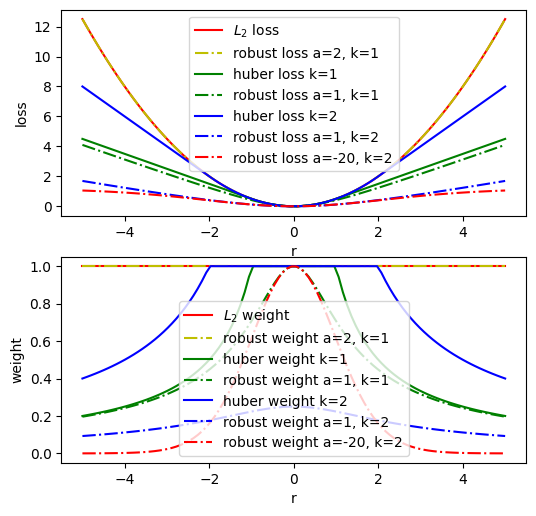

In [56]:
# A Generalized Robust Kernel Functions

import matplotlib.pyplot as plt
import numpy as np


def huber_loss(r, k):
    y = np.zeros(r.shape)
    y[np.abs(r) < k] = 0.5 * (r[np.abs(r) < k] ** 2)
    y[np.abs(r) >= k] = k * (np.abs(r[np.abs(r) >= k]) - 0.5*k)
    return y

def huber_weight(r, k):
    y = np.ones(r.shape)
    y[np.abs(r) >= k] = k / np.abs(r[np.abs(r) >= k])
    return y

def robust_loss(r, a, k):
    assert(a != 0)
    if a == 2:
        return 0.5 * (r/k)**2
    return np.abs(a-2) / a * (((r/k)**2/np.abs(a-2)+1)**(a/2.0)-1)

def robust_weight(r, a, k):
    assert(a != 0)
    if a == 2:
        return np.ones(r.shape, dtype=np.float32) / (k**2)
    return ((r/k)**2/np.abs(a-2)+1)**(0.5*a-1) / (k**2)
    
r = np.linspace(-5, 5, 100)

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6,6), dpi=100)

ax1.plot(r, 0.5 * r**2, '-r', label='$L_2$ loss')
ax1.plot(r, robust_loss(r,2,1), '-.y', label='robust loss a=2, k=1')
ax1.plot(r, huber_loss(r,1), '-g', label='huber loss k=1')
ax1.plot(r, robust_loss(r,1,1), '-.g', label='robust loss a=1, k=1')
ax1.plot(r, huber_loss(r,2), '-b', label='huber loss k=2')
ax1.plot(r, robust_loss(r,1,2), '-.b', label='robust loss a=1, k=2')
ax1.plot(r, robust_loss(r,-10,2), '-.r', label='robust loss a=-20, k=2')

ax1.set_ylabel('loss')
ax1.set_xlabel('r')
ax1.legend()

ax2.plot(r, np.ones(r.shape), '-r', label='$L_2$ weight')
ax2.plot(r, robust_weight(r, 2, 1), '-.y', label='robust weight a=2, k=1')
ax2.plot(r, huber_weight(r,1), '-g', label='huber weight k=1')
ax2.plot(r, robust_weight(r, 1, 1), '-.g', label='robust weight a=1, k=1')
ax2.plot(r, huber_weight(r,2), '-b', label='huber weight k=2')
ax2.plot(r, robust_weight(r,1,2), '-.b', label='robust weight a=1, k=2')
ax2.plot(r, robust_weight(r, -20, 1), '-.r', label='robust weight a=-20, k=2')
ax2.set_ylabel('weight')
ax2.set_xlabel('r')
ax2.legend()

#

#### Construct Probability Distributions from Robust Kernels

Recall that we are trying to maximize the log-likelihood: 
$$
x^* = \underset{x}{\operatorname{argmax}} \sum_i log(p(z_i|x)) 
$$
In this section, we are trying to minimize the robust cost: 
$$
x^*  = \underset{x}{\operatorname{argmin}} \sum_i{\rho(r_i(x))}
$$

By connecting these two together, we can get: 
$$
p(z_i | x) = p(r_i(x, z_i)) = \frac{1}{kZ(\alpha)}e^{-\rho(r_i, \alpha, k)}
$$
where $Z(\alpha) = \int{e^{-\rho(r_i, \alpha, 1)}}$

When optimizing hyperparameter $\alpha$ and state variable $x$ together, there are a couple of things to note:
1. $Z(\alpha)$ is unbounded for $\alpha < 0$. So a solution will be cut off integral to be in $[-\tau, \tau]$. Then, the probability distribution is not well normalized. But for maximizing log-likelihood purpose, it should work fine.
2. $x^*, \alpha^* = \underset{x, \alpha}{\operatorname{argmax}} \sum_i log(p_{\alpha}(z_i|x)) = \underset{x, \alpha}{\operatorname{argmin}}\sum_i\rho(r_i,\alpha,k) + log(kZ(\alpha))$. Be aware that the final cost function has a regularization term.

## Factor Potentials as Gaussian Mixtures

In the previous section, we assume the likelihood $p(z|x)$ follows Gaussian distribution. As we pointed out earlier, in practice, residuals sometime are not Gaussian distributed. This is exactly why we come up with robust kernels. However, using these robust kernels still assumes that residuals follows a symmetric distribution. Now let's approach the problem in a different way which assumes that residuals follow a Gaussian mixture model:

$$
p(z_i | x) \sim \sum_kw^i_kN(\mu^i_k, \Sigma^i_k)
$$

As shown in the figure below, the mixture model (red) is not symmetric anymore. It can represent arbitrary distribution given proper components. But this also brings a difficulty in optimization. Remember we are trying to maximize log-likelihood and we can convert it into a least square problem with the assumption that residuals follow a single Gaussian distribution. But without Gaussian mixture, we can we do? 
$$
x^* = \underset{x}{\operatorname{argmax}} \prod p (z_i | x) 
= \underset{x}{\operatorname{argmax}} \sum_i log(\sum_kw^i_kN(\mu^i_k, \Sigma^i_k)) 
$$

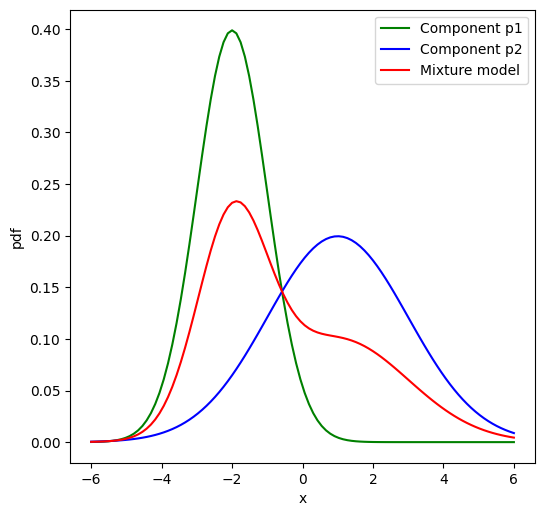

In [55]:
# Gaussian Mixture Model

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

x = np.linspace(-6, 6, 100)
w1 = 0.5
u1 = -2
s1 = 1

w2 = 0.5
u2 = 1
s2 = 2

p1 = norm.pdf(x, u1, s1)
p2 = norm.pdf(x, u2, s2)

fig, (ax1) = plt.subplots(
    nrows=1, ncols=1, figsize=(6,6), dpi=100)

ax1.plot(x, p1, 'g', label='Component p1')
ax1.plot(x, p2, 'b', label='Component p2')
ax1.plot(x, w1*p1+w2*p2, 'r', label='Mixture model')

ax1.set_ylabel('pdf')
ax1.set_xlabel('x')
ax1.legend()

#

### Max-Mixture Model

In order to convert the maximization of log-likelihood with Gaussian mixture into a nice least square problem, we try to use the max component in the mixtures to approximate it:

$$
p(z_i | x) \sim \sum_kw^i_kN(\mu^i_k, \Sigma^i_k) \sim 
\frac{\underset{k}{\operatorname{max}}\sum_kw^i_kN(\mu^i_k, \Sigma^i_k)}{\gamma^i}
$$

Note that a normalization factor $\gamma$ is required in order to ensure that a max mixture integrates to $1$. However, for maximizing log-likelihood, it is just added as a constant ($-log(\gamma)$). So it won't affect the final solution of $x^*$:

$$
x^* = \underset{x}{\operatorname{argmax}} \sum_i{log(\frac{w^i_{k^*}}{\gamma^i}\eta_i e^{-\frac{1}{2}(\mu^i_{k^*})^T{\Sigma^i_{k^*}}^{-1}(\mu^i_{k^*})})} = \underset{x}{\operatorname{argmax}} \sum_i{log(e^{-\frac{1}{2}(\mu^i_{k^*})^T{\Sigma^i_{k^*}}^{-1}(\mu^i_{k^*})})}
$$

I general max-mixture is a very good approximation to sum-mixture. I think a good practice is that when you define mixture model of the residuals, check how close the max-mixture matches the sum-mixture.

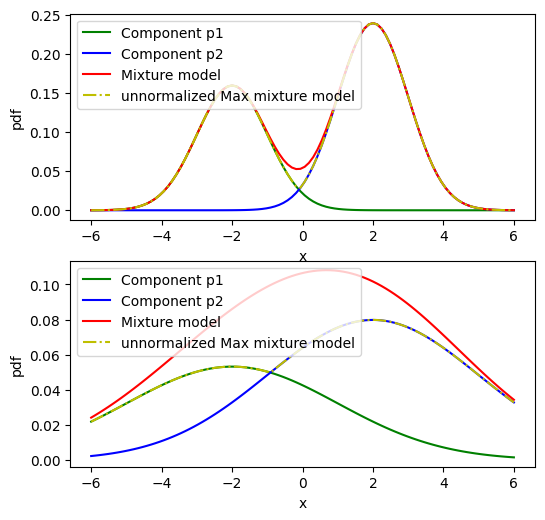

In [75]:
# Gaussian Mixture Model

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

x = np.linspace(-6, 6, 100)
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6,6), dpi=100)

w1 = 0.4
u1 = -2
s1 = 1

w2 = 1-w1
u2 = 2
s2 = 1

p1 = w1*norm.pdf(x, u1, s1)
p2 = w2*norm.pdf(x, u2, s2)

ax1.plot(x, p1, 'g', label='Component p1')
ax1.plot(x, p2, 'b', label='Component p2')
ax1.plot(x, p1+p2, 'r', label='Mixture model')
ax1.plot(x, [pa if pa > pb else pb for (pa, pb) in zip(p1, p2)], 'y-.', label='unnormalized Max mixture model')
ax1.set_ylabel('pdf')
ax1.set_xlabel('x')
ax1.legend()

w1 = 0.4
u1 = -2
s1 = 3

w2 = 1-w1
u2 = 2
s2 = 3

p1 = w1*norm.pdf(x, u1, s1)
p2 = w2*norm.pdf(x, u2, s2)

ax2.plot(x, p1, 'g', label='Component p1')
ax2.plot(x, p2, 'b', label='Component p2')
ax2.plot(x, p1+p2, 'r', label='Mixture model')
ax2.plot(x, [pa if pa > pb else pb for (pa, pb) in zip(p1, p2)], 'y-.', label='unnormalized Max mixture model')
ax2.set_ylabel('pdf')
ax2.set_xlabel('x')
ax2.legend()

#

### Sum-Mixture Model

$$
x^* = \underset{x}{\operatorname{argmax}} \sum_i{log(w_i\eta_i e^{-\frac{1}{2}(\mu_i)^T{\Sigma^i_{k^*}}^{-1}(\mu_i)})}
$$



## Robust Kernel with Gaussian Mixture

## Self-supervised Learned Robust Kernel 

References:
- Olson, `Inference on networks of mixtures for robust robot mapping`
- Engel, `Large-Scale Direct SLAM and 3D Reconstruction in Real-Time`
- Barron, `A General and Adaptive Robust Loss Function`
- Chebrolu, `Adaptive Robust Kernels for Non-Linear Least Squares Problems`
- Pfeifer, https://www.tu-chemnitz.de/etit/proaut/en/research/libRSF.html